# Tests for strobe functionality

In [2]:
# Reload modules every time code is called. Set autoreload 0 to disable
%load_ext autoreload
%autoreload 2

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time

import lightlab.util.sweep as sUtil
import lightlab.util.characterize as chize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
livePlots = False

## The system
This is the system. It has actuate and measurement methods. The actuate has an argument that determines the equilibrium response. The temporal response is nonlinear because its frequency depends on the actuation *value*. Otherwise, it is basically damped oscillation in this case.

When the actuation occurs, the temporal response starts. So what is actually measured depends also on the real time between actuation call and measurement call.

In [4]:
# System parameters
dynamicDecay = .004
measurementDelay = dynamicDecay*2 # Measurement takes longer than the transient effect

def eqRespFun(x):
    return x**2

class DynamicSystem():
    def __init__(self):
        self.actTime = time.time()
        self.actVal = 1
        
    def equilibriumResponse(self):
        return eqRespFun(self.actVal)
        
    def temporalResponse(self, t):
        ''' Damped oscillation whose period depends on the actVal
        '''
        period = np.max((.04 / self.actVal, .001))
        decay = np.exp(-t/dynamicDecay)
        osc = np.cos(2*np.pi / period * t)
        return (1 - osc*decay)
        
    def actu(self, a, wait=0):
        self.actTime = time.time()
        self.actVal = a
        time.sleep(wait)
        
    def meas(self):
        dt = time.time() - self.actTime
        m = self.temporalResponse(dt) * self.equilibriumResponse()
        # Now do some post processing or plotting, or GPIB communication
        # Some of the delay is random
        time.sleep(measurementDelay * (1 + np.random.rand()) / 2)
        return m
        
sys = DynamicSystem()

## A common problem
Suppose we want to do some procedure, like a sweep. We are interested in repeatability. The function ``trial`` just does a sweep several times, comparing the result to the equilibrium expectation.

It is inconsistent because the time after measurement fluctuates randomly, and the system response is time dependent

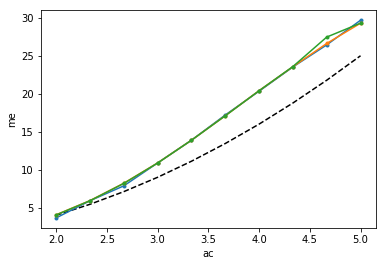

In [10]:
dom = np.linspace(2,5,10)
def trial(nTrial, wait=0):
    ''' trial evaluates success of matching the measured value to the actual equilibrium value
    '''
    fi, ax = plt.subplots()
    plt.plot(dom, eqRespFun(dom), '--k')
    err = 0
    for i in range(nTrial):
        actSwp = sUtil.NdSweeper()
        actSwp.setMonitorOptions(stdoutPrint=False)
        actSwp.addActuation('ac', lambda a: sys.actu(a, wait=wait), dom)
        actSwp.addMeasurement('me', sys.meas)
        actSwp.gather()
        actSwp.plot(axArr=ax)
        err = max(err, np.max(np.abs(eqRespFun(dom) - actSwp.data['me'])))
    return err

err = trial(3, wait=dynamicDecay)
assert err > 1

It is not quite repeatable or on target. That is because the system is still settling when a measurement is taken. We could wait to settle after actuating, but for how long? If we wait too long, it slows down our procedures a lot.

We need to characterize the temporal response that is occuring faster than a measurement delay.

The problem is that our measurement causes a delay due to GPIB communication, buffering, integration, post processing, etc. The delay can be 
* longer than the interesting dynamics, and/or
* unrepeatable

The answer is a strobe test.

## Using sweptStrobe
The idea of the strobe is to only perform one measurement for every actuation. The time between actuate and measure *calls* is time locked and varied by a known value over each iteration. That means there is no need to rely on the time between subsequent measure calls and returns.

sweptStrobe subsumes a normal NdSweeper into a new strobe sweep. The result also has options for live plotting and xKeys, yKeys, etc. It is executed with gather().

Generic sweep in ac
Dim-0...
1/1...
Sweep completed!
Generic sweep in ac
Dim-0...
1/10...
2/10...
3/10...
4/10...
5/10...
6/10...
7/10...
8/10...
9/10...
10/10...
Sweep completed!


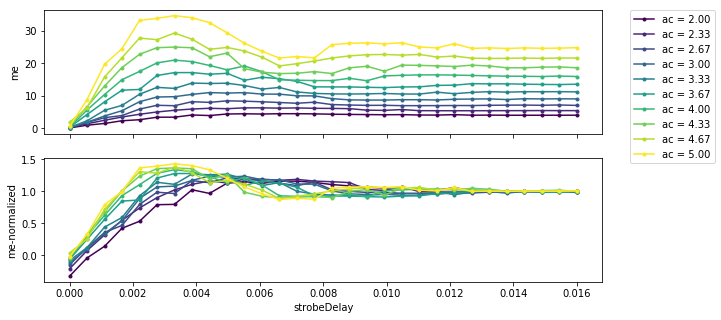

In [11]:
actSwp = sUtil.NdSweeper()
actSwp.addActuation('ac', sys.actu, dom)
actSwp.addMeasurement('me', sys.meas)
stb = chize.sweptStrobe(actSwp, resetArg=1, nPts=30, maxDelay=4*dynamicDecay)
stb.setPlotOptions(yKey=('me', 'me-normalized'))
stb.setMonitorOptions(runServer=False, livePlot=livePlots, plotEvery=10, stdoutPrint=False)
stb.gather()
if not livePlots:
    stb.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1141f2cc0>],
      dtype=object)

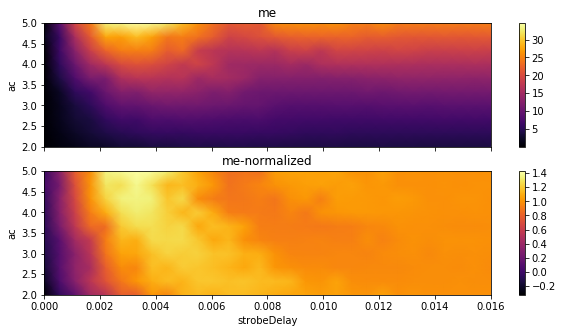

In [12]:
# Other plotting
stb.setPlotOptions(plType='surf')
stb.plot()

### Solving the problem. 
This should have been obvious by now.

Strobe analysis is used for much more characterization than just telling you how long to wait to equilibrate.

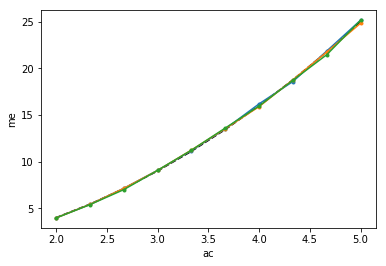

In [13]:
err = trial(3, wait=4*dynamicDecay)
assert err < 1